In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

#path to folders for training data
mask_path = Path("dataset") / "with_mask"
no_mask_path = Path("dataset") / "without_mask"

images = []
labels = []

print("Load data...")

for img in mask_path.glob("*.jpg"):
    #Load the image from disk
    img = image.load_img(img)
    
    img = img.resize([224,224])
    
    #Convert the image to an array
    image_array = image.img_to_array(img)
    
    #Add the image to the list of images
    images.append(image_array)
    
    #For each "mask image", the expected value should be 1
    labels.append(1)

for img in no_mask_path.glob("*.jpg"):
    #Load the image from disk
    img = image.load_img(img)
    
    img = img.resize([224,224])
    
    #Convert the image to an array
    image_array = image.img_to_array(img)
    
    #Add the image to the list of images
    images.append(image_array)
    
    #For each "not mask image", the expected value should be 0
    labels.append(0)
 

    # Convert the array with train images we loaded into a numpy array
X_train = np.array(images)

# Convert the train lables array into a numpy array
Y_train = np.array(labels)

# transform labels into arrays with two elements
Y_train = to_categorical(Y_train)

# Convert data from integer to floating point
X_train = X_train.astype("float32")

# Normalizing data between 0 and 1
X_train = X_train/255

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(X_train, Y_train,
	test_size=0.20, stratify=labels, random_state=42)


# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
history = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	epochs=EPOCHS)
    

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("MobileNetMaskDetector.h5")


Load data...


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[INFO] compiling model...
[INFO] training head...


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
188/188 [==============================] - 228s 1s/step - loss: 0.2973 - accuracy: 0.8965 - val_loss: 0.0867 - val_accuracy: 0.9729
Epoch 2/20
188/188 [==============================] - 218s 1s/step - loss: 0.1098 - accuracy: 0.9661 - val_loss: 0.0584 - val_accuracy: 0.9762
Epoch 3/20
188/188 [==============================] - 213s 1s/step - loss: 0.0857 - accuracy: 0.9739 - val_loss: 0.0511 - val_accuracy: 0.9768
Epoch 4/20
188/188 [==============================] - 201s 1s/step - loss: 0.0677 - accuracy: 0.9775 - val_loss: 0.0449 - val_accuracy: 0.9782
Epoch 5/20
188/188 [==============================] - 203s 1s/step - loss: 0.0669 - accuracy: 0.9790 - val_loss: 0.0400 - val_accuracy: 0.9821
Epoch 6/20
188/188 [==============================] - 198s 1s/step - loss: 0.0575 - accuracy: 0.9837 - val_loss: 0.0375 - val_accuracy: 0.9828
Epoch 7/20
188/188 [==============================] - 191s 1s/step - loss: 0.0590 - accuracy: 0.9830 - val_loss: 0.0356 - val_accuracy: 0.9848

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


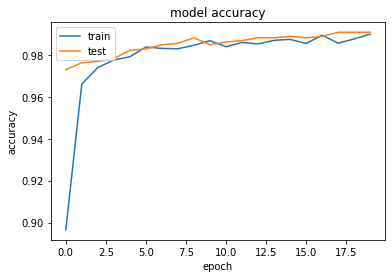

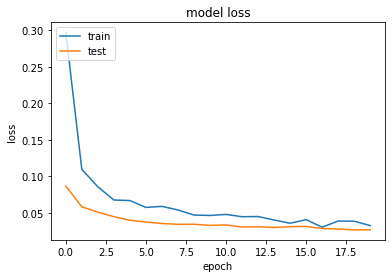

In [4]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()